In [1]:
from __init__ import *
from rain import *
from common import *
from event import *

%matplotlib inline
import mpld3 

In [2]:
path = './input/'

rg = Rain(path=path, name='StLouis_MSD_gage_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rad = Rain(path=path, name='StLouis_MSD_radar_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rg.ll_file = 'StLouis_MSD_lat_lon_{YEAR}.csv'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll
p = RadarGage(gage=rg, radar=rad)
p.get_nonan()

In [3]:
p.save_path = rg.save_path = rad_save_path = './output/AGU/'

1) Map of probability of wet 15-minute periods with 5 mm threshold (gage and radar)

/home/jsignell/miniconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


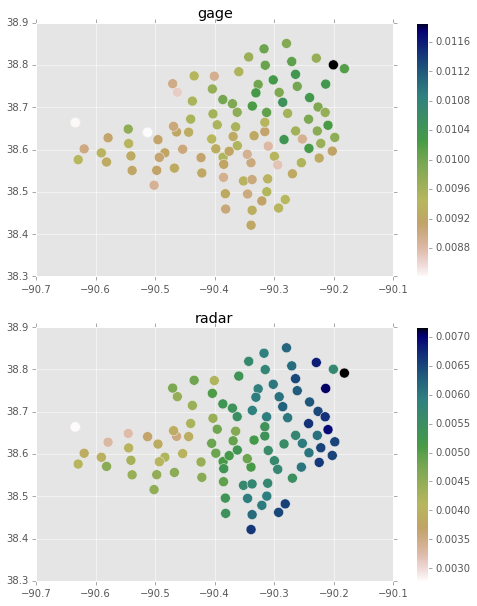

In [4]:
p.thresh = 1*p.per_hour
p.plot_prob_wet(time_step='15min', gage=p.list_gages(), bar=False, map=True, sharec=False, top_to_bottom=True, hide_title=True)

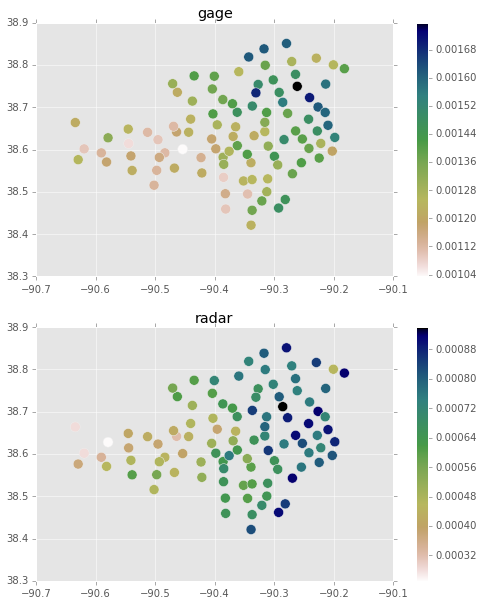

In [5]:
p.thresh = 5*p.per_hour
p.plot_prob_wet(time_step='15min', gage=p.list_gages(), bar=False, map=True, sharec=False, top_to_bottom=True, hide_title=True)

2) Map of probability of wet 24 hour periods with 25 mm threshold (gage and radar)

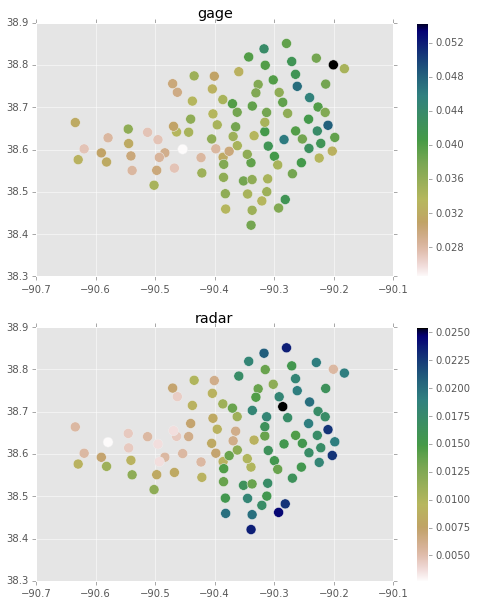

In [7]:
p.thresh = 25 * p.per_hour
p.plot_prob_wet(time_step='24H', base=12, gage=p.list_gages(), bar=False, map=True, sharec=False, top_to_bottom=True, hide_title=True)

3) Mean diurnal cycle of rainfall (gage and radar) for JJA using all gage locations: 

    a) probability of positive rainfall and 
    b) mean rainfall for positive rain periods [ also June, July and August separately ] 

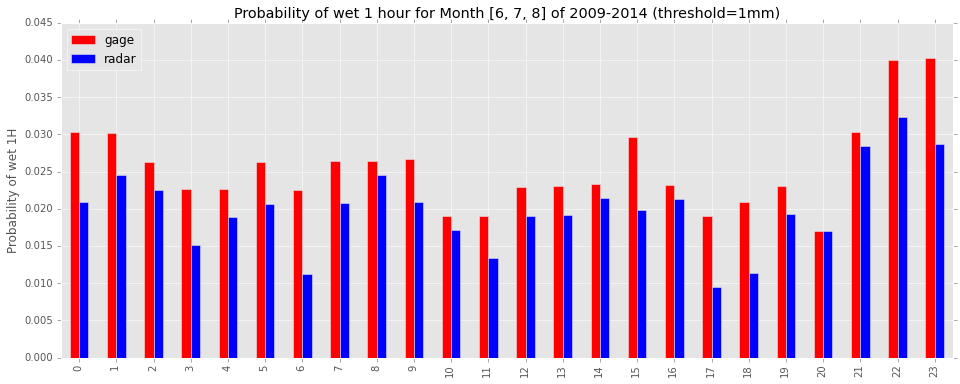

In [8]:
p.thresh = 1*p.per_hour
p.plot_prob_wet(time_step='1H', interval='diurnal', m=[6, 7, 8], color=['r','b'])

In [9]:
wet_gage = {}
wet_radar = {}
for h in range(24):
    wet_gage.update({h: p.gb.get_group(h).gage[p.gb.get_group(h).gage>=p.thresh]})
    wet_radar.update({h: p.gb.get_group(h).radar[p.gb.get_group(h).radar>=p.thresh]})

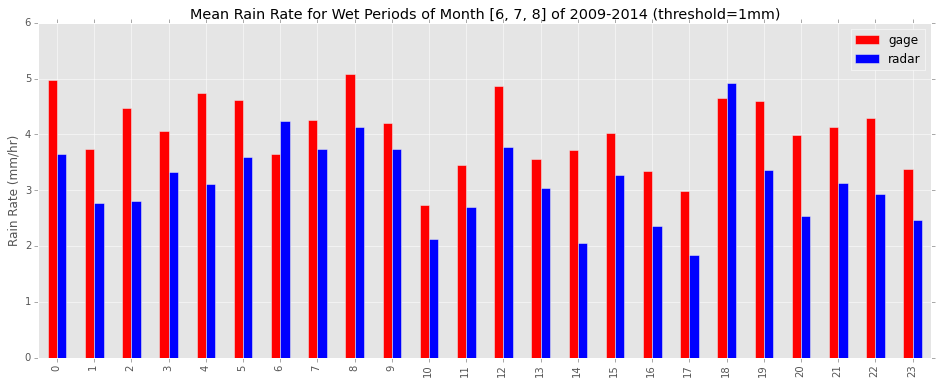

In [11]:
p.wet = pd.DataFrame({'gage': pd.DataFrame(wet_gage).mean()/4, 'radar': pd.DataFrame(wet_radar).mean()/4})
p.wet.plot(kind='bar', figsize=(16,6), color=('r','b'))
plt.ylabel('Rain Rate (mm/hr)')
title = 'Mean Rain Rate for Wet Periods of Month [6, 7, 8] of 2009-2014 (threshold={t}mm)'.format(t=p.thresh/4)
plt.title(title)
plt.savefig(p.save_path+title+'.png')
plt.show()

4) Map of:

    a) time of peak probability of rainfall
    b) mean probability at the time of peak probability for gage and radar

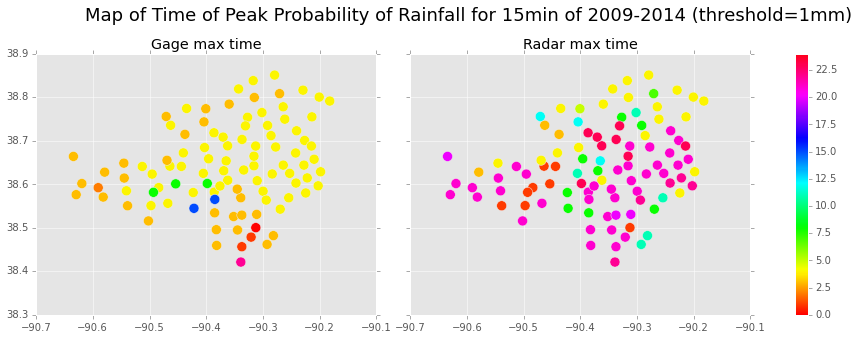

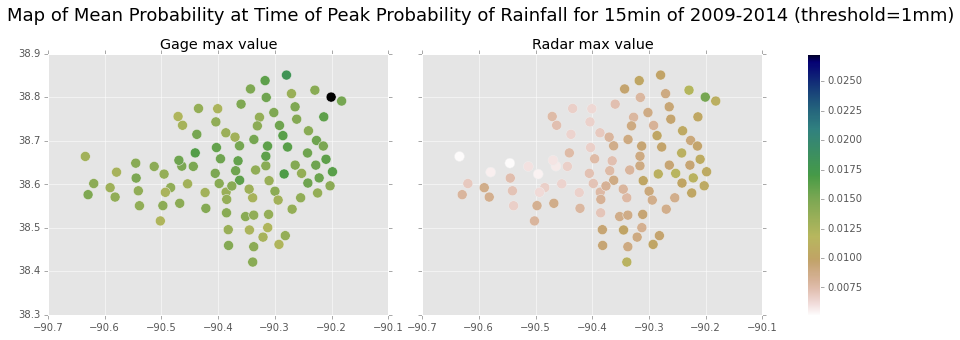

In [13]:
rg.thresh = rad.thresh = p.thresh = 1*p.per_hour

rg.plot_prob_wet(gage=p.list_gages(), time_step='15min', interval='diurnal', bar=False, m=[4,5,6,7,8,9])
rad.plot_prob_wet(gage=p.list_gages(), time_step='15min', interval='diurnal', bar=False, m=[4,5,6,7,8,9])

df = pd.DataFrame({'Gage max time': rg.df.idxmax(), 'Radar max time': rad.df.idxmax()})
Event(p.ll.join(df)).map_rain(cmap='hsv', sharec=(0,24), save_path=p.save_path, 
         title='Map of Time of Peak Probability of Rainfall for 15min of 2009-2014 (threshold={t}mm)'.format(t=p.thresh/p.per_hour))

df = pd.DataFrame({'Gage max value': rg.df.max(), 'Radar max value': rad.df.max()})
Event(p.ll.join(df)).map_rain(save_path=p.save_path, sharec=True,
         title='Map of Mean Probability at Time of Peak Probability of Rainfall for 15min of 2009-2014 (threshold={t}mm)'.format(t=p.thresh/p.per_hour))

4) Map of:

    a) time of peak rainfall given that it is raining
    b) value of peak rainfall given that it is raining

In [14]:
def get_wet(df, thresh, time_step=None, base=0):
    resample_kwargs = get_resample_kwargs(df)
    rate = df.resample(time_step, base=base, **resample_kwargs)
    resample_kwargs.update({'how':'sum'})
    wet = df.resample(time_step, base=base, **resample_kwargs)
    wet_rate = rate[wet>=thresh]
    return wet_rate

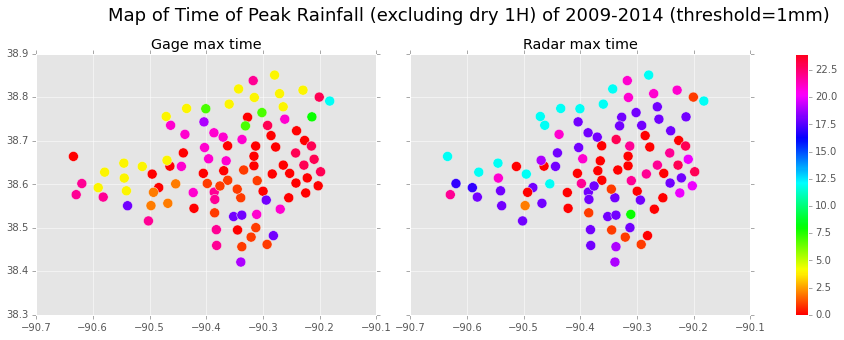

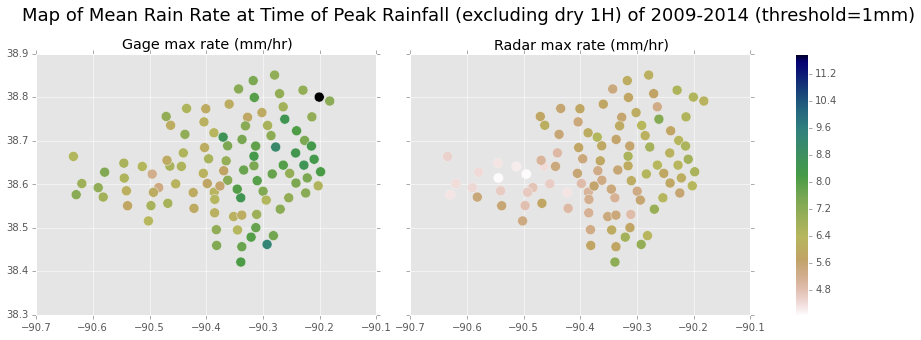

In [15]:
wet_rate = get_wet(p.rate.gage, p.thresh, time_step='1H')
gb = wet_rate.groupby(wet_rate.index.hour)
df_gage = gb.mean()
wet_rate = get_wet(p.rate.radar, p.thresh, time_step='1H')
gb = wet_rate.groupby(wet_rate.index.hour)
df_radar = gb.mean()

df = pd.DataFrame({'Gage max time': df_gage.idxmax(), 'Radar max time': df_radar.idxmax()})
Event(p.ll.join(df)).map_rain(cmap='hsv', sharec=(0,24), save_path=p.save_path, 
         title='Map of Time of Peak Rainfall (excluding dry 1H) of 2009-2014 (threshold={t}mm)'.format(t=p.thresh/p.per_hour))

df = pd.DataFrame({'Gage max rate (mm/hr)': df_gage.max(), 'Radar max rate (mm/hr)': df_radar.max()})
Event(p.ll.join(df)).map_rain(save_path=p.save_path, sharec=True,
         title='Map of Mean Rain Rate at Time of Peak Rainfall (excluding dry 1H) of 2009-2014 (threshold={t}mm)'.format(t=p.thresh/p.per_hour))

4) Map of:
    
    a) time of peak rainfall
    b) mean rainfall at the time of peak rainfall for gage and radar

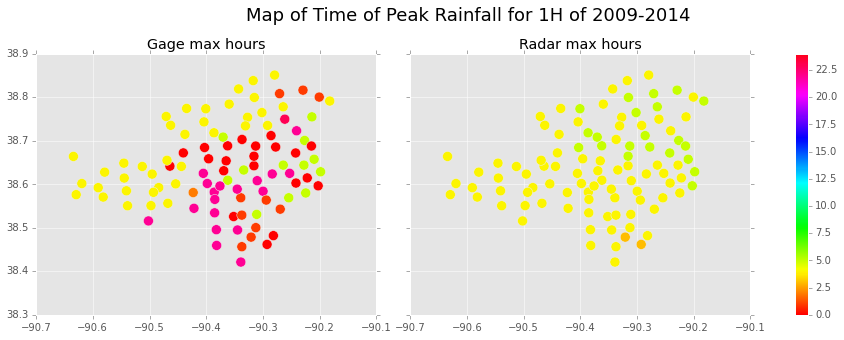

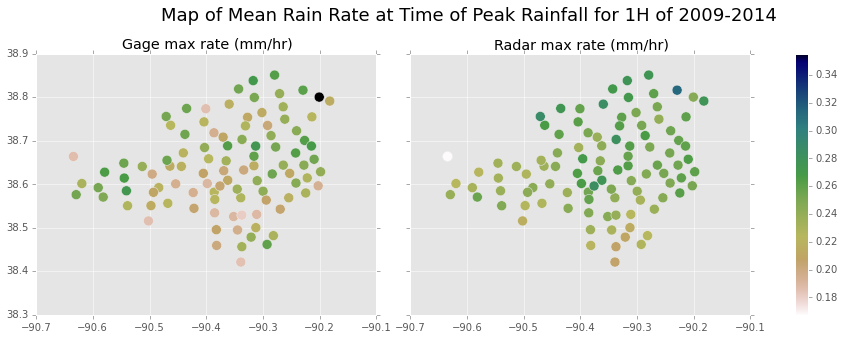

In [16]:
rg.plot_rate(gage=p.list_gages(), time_step='1H', interval='diurnal', bar=False, m=[4,5,6,7,8,9])
rad.plot_rate(gage=p.list_gages(), time_step='1H', interval='diurnal', bar=False, m=[4,5,6,7,8,9])

df = pd.DataFrame({'Gage max hours': rg.df.idxmax(), 'Radar max hours': rad.df.idxmax()})
Event(p.ll.join(df)).map_rain(cmap='hsv', sharec=(0,24), 
         save_path=p.save_path,
         title='Map of Time of Peak Rainfall for 1H of 2009-2014')

df = pd.DataFrame({'Gage max rate (mm/hr)': rg.df.max(), 'Radar max rate (mm/hr)': rad.df.max()})
Event(p.ll.join(df)).map_rain(sharec=True, save_path=p.save_path,
         title='Map of Mean Rain Rate at Time of Peak Rainfall for 1H of 2009-2014')

6) Maps of mean rainfall (gage and radar) for April, May, June, July, August and September

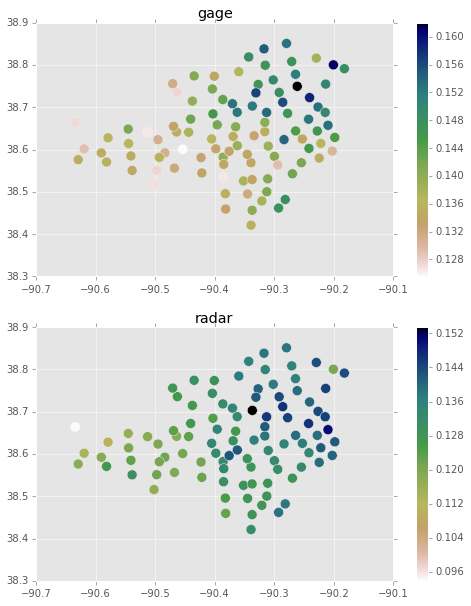

In [17]:
p.plot_rate(gage=p.list_gages(), bar=False, map=True, top_to_bottom=True, hide_title=True)

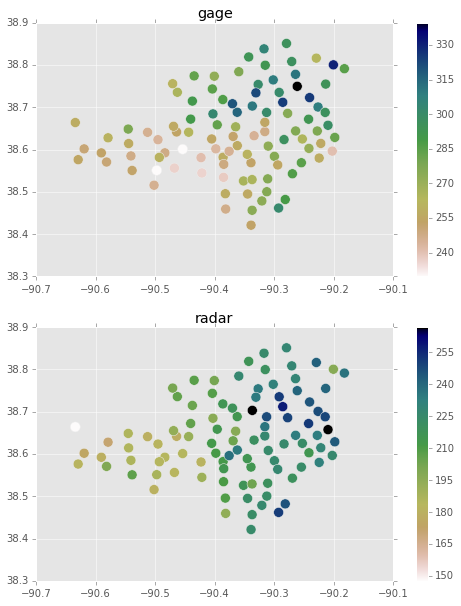

In [19]:
d, dt = get_index(p.rate, 'date_time')
gb = p.rate.groupby(dt.month)

df6 = gb.get_group(6).mean(axis=d)*30*24 # hours in June
df7 = gb.get_group(7).mean(axis=d)*31*24 # hours in July
df8 = gb.get_group(8).mean(axis=d)*31*24 # hours in August
df = df6+df7+df8    
Event(p.ll.join(df)).map_rain(save_path=p.save_path,
         title='Map of Mean Rain Accumulation for JJA of 2009-2014',
         top_to_bottom=True, hide_title=True)

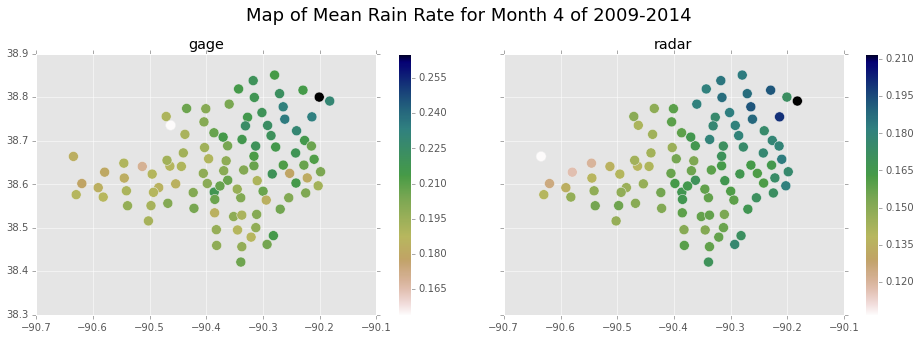

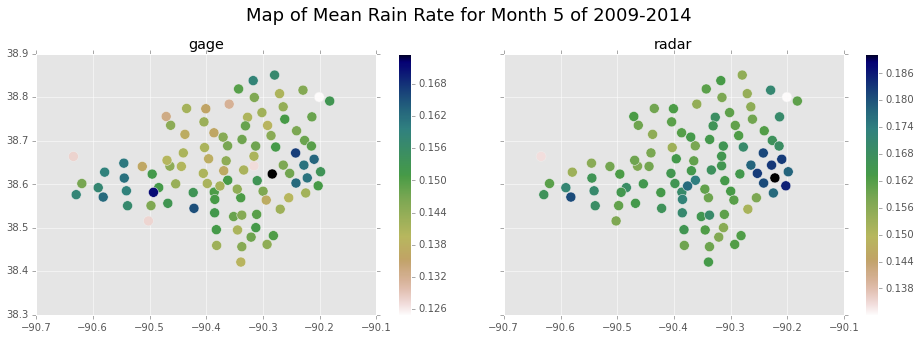

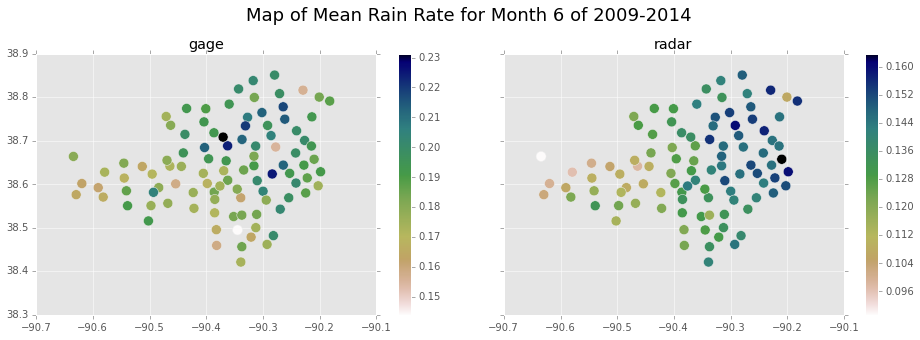

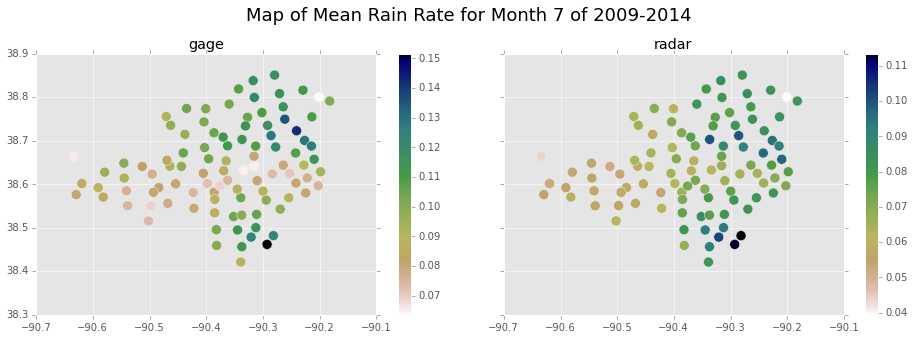

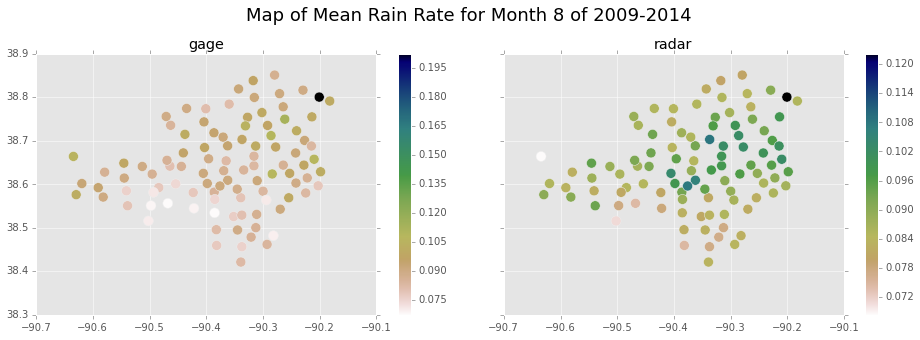

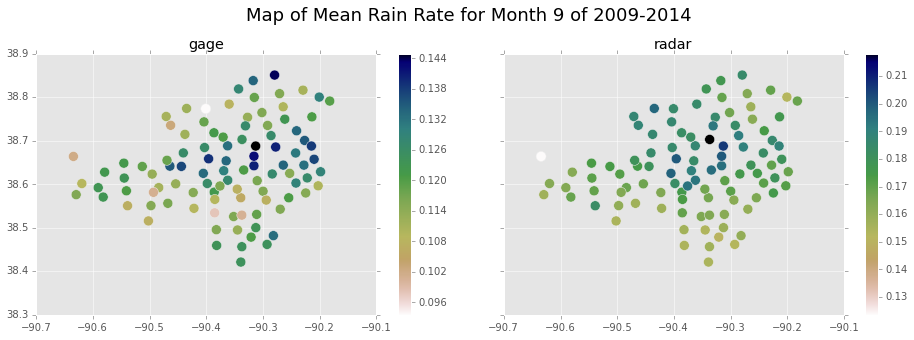

In [20]:
d, dt = get_index(p.rate, 'date_time')
gb = p.rate.groupby(dt.month)
for m in [4,5,6,7,8,9]:
    df = gb.get_group(m).mean(axis=d)
    Event(p.ll.join(df)).map_rain(save_path=p.save_path,
         title='Map of Mean Rain Rate for Month {m} of 2009-2014'.format(m=m))